# A Simple Implementation of Regularized Linear Regression
This notebook goes over a implementation of Regularized Linear Regression in Python. The purpose of this notebook is to mainly break down how the linear regression algorithm/model works both through a bare bones implementation and visualization.

First, let's define the key formulas we will need to implement for our model to function:
### The Hypothesis Function
This function will actually be used to predict our outputs ($y$) value based on a given set of inputs ($x$). In this case, our $h(x)$ is going to be a linear function of $n$ dimensional inputs; $\{x_{1}, ..., x_{n}\}$, along with $\{\theta_{0}, ..., \theta_{n}\}$ trainable parameters:

$h_{\theta}(x)  =  \theta_{0} + \theta_{1} * x_{1} + ... + \theta_{n} * x_{n}  =  \theta_{0} + \sum_{i=1}^{n} \theta_{i}x_{i}$

### The Cost Function
This function will be used to assess how well our model can predict the output based on the input $x$ for each labelled data point $\{x, y\}$. We will be using the mean squared error to calculate the cost of each prediction. The $m$ value is the number of training points. Both $x^{(i)}$ and $\theta$ are vectors of size $n\times1$. The second term is the regularization term. When the cost function is being optimized, it will aide in stopping the model from overfitting the training parameters onto the training set. $\lambda$ will control how much weight we want to give the regularization term, this means if $\lambda$ is set too large, the model might have a high bias and perform poorly. Note, $\theta_{0}$ is not regularized.

$J(\theta)  =  \frac{1}{2m} \sum_{i=1}^{m} (h_{\theta}(x^{(i)}) - y^{(i)})^{2} + \frac{\lambda}{2m}\sum_{j=1}^{n} \theta_{j}^{2}$

### The Gradient Calculation Function
The optimization of the cost function will be done with gradient descent. For this, the gradients of all the trainable parameters must be calculated, that is, the partial derivitives of $\{\frac{\partial J(\theta)}{\partial \theta_{0}}, ..., \frac{\partial J(\theta)}{\partial \theta_{n}}\}$. After calculating the partiel derivatives, the result should be:

$\frac{\partial J(\theta)}{\partial \theta_{0}}  =  \frac{1}{m}  \sum_{i=1}^{m} {(h_{\theta}(x^{(i)}) - y^{(i)})}$

$\frac{\partial J(\theta)}{\partial \theta_{j}}  =  \frac{1}{m}  \sum_{i=1}^{m} {(h_{\theta}(x^{(i)}) - y^{(i)}) x_{j} ^{i}  +  \frac{\lambda}{m} \theta_{j}}   \hspace{10mm} \text{for} \hspace{3mm}j = 1, ..., n$

With these calulations, the gradient descent algorithm can be used to optimize the cost function and train the model. Here is a vectorized implementation of Regularized Linear Regression. The training set is decoupled from the actual regression trainer to make it easier to switch between batch, mini-batch, and stochastic gradient descent. Input data X is an m by n matrix and input label y is a m by 1 vector.

In [1]:
import numpy as np

class RegularizedLinearRegression:
    def __init__(self, n=1, reg_lambda=0.01, learning_rate=0.001):
        self.n = n
        self.theta = np.zeros((n + 1, 1))
        self.grad = np.zeros((n + 1, 1))
        self.reg_lambda = reg_lambda
        self.learning_rate = learning_rate
        
    def train(self, X, y, iterations=None):
        
        # get number of training examples and insert m by 1 bias vector
        m = X.shape[0]
        X = np.insert(X, [0], np.ones((m, 1)), axis=1)
        
        cost_hist = np.zeros(iterations)
        
        for i in range(iterations):
            
            # run batch gradient descent step and calculate cost of updated theta
            self._gradient_descent_batch_step(X, y)
            cost_hist[i] = self._cost_func(X, y)
            
        return cost_hist
            
    def _gradient_descent_batch_step(self, X, y):

        # compute gradients
        self.grad = self._compute_gradients(X, y)
        
        # update theta
        self.theta = self.theta - self.learning_rate * self.grad
        
    def _hypothesis_func(self, X, theta=None):
        if theta is None:
            theta = self.theta
            
        # hypothesis function for prediction
        return np.matmul(X, theta)
    
    def _cost_func(self, X, y, theta=None):
        if theta is None:
            theta = self.theta
            
        # mean squared error cost
        m = X.shape[0]
        return 1/(2 * m) * (np.sum(np.power(np.subtract(self._hypothesis_func(X, theta), y), 2))  +  self.reg_lambda * np.sum(np.power(theta[1:], 2)))
        
    def _compute_gradients(self, X, y):
        m = X.shape[0]
        grad = np.zeros((self.n + 1, 1))
        
        # calculate gradients of theta (calculated grad of theta_0 again to remove the regularization calculation from the vectoried cal.)
        grad = (1/m) * np.transpose(np.matmul(np.transpose(np.sum(np.subtract(self._hypothesis_func(X), y), axis=1, keepdims=True)), X)) + (self.reg_lambda/m) * self.theta 
        grad[0] = (1/m) * np.sum(np.subtract(self._hypothesis_func(X), y))
        
        return grad

### Gradient Checking
Now that gradient descent has been implementated, there needs to be some way to check that the gradient calculations are in fact accurate and there is no logic error present. To do this, gradient checking must be implemented. Gradient checking follows the basic principles of computing tangents of functions both through limits and derivatives and then comparing the two outputs to make sure they are consistent with one another.

Here is a simple example with a polynomial function ($n=1$). 

Polynomial function

$f(x) = x^2$

Tangent (derivative) Calculation througn limits ($h$ being a small value; $h < 0.01$ )

$f'(x) = \frac{f(x + h) - f(x - h)}{2 * h}$

Tangent (derivative) Calculation througn derivative

$f'(x) = 2x$

Now, sample random values of $x$, choose a small $h$ value, and compare the derivative outputs given by the two methods to confirm that both methods are working correctly. You should get similiar values from both methods.

This concept can be applied to the cost function and gradients of the linear regression model. The only slight change is that  the cost function contains more than one parameter; $\{\theta_{0}, ..., \theta_{n}\}$. To overcome this, change only one parameter at a time. $h$ will now be a (n + 1) by 1 vector of zeros, with only one element at a time having a slight deviation. Then, cycle through each element of $\{\theta_{0}, ..., \theta_{n}\}$ to calculate every gradient using the limit method. Below is a modified Regularized Linear Regression with gradient checking.

In [206]:
import numpy as np

class RegularizedLinearRegression:
    def __init__(self, n=1, reg_lambda=0.01, learning_rate=0.001):
        self.n = n
        self.theta = np.zeros((n + 1, 1))
        self.grad = np.zeros((n + 1, 1))
        self.reg_lambda = reg_lambda
        self.learning_rate = learning_rate
        
    def train(self, X, y, iterations=None):
        
        # get number of training examples and insert m by 1 bias vector
        m = X.shape[0]
        X = np.insert(X, [0], np.ones((m, 1)), axis=1)
        
        cost_hist = np.zeros(iterations)
        
        for i in range(iterations):
            
            # run batch gradient descent step and calculate cost of updated theta
            self._gradient_descent_batch_step(X, y)
            cost_hist[i] = self._cost_func(X, y)
            
        return cost_hist
    
    def check_gradients(self, sample_size=10, epsilon=1e-3):
        
        # generate random samples
        X_samples = np.random.rand(sample_size, self.n)
        X_samples = np.insert(X_samples, [0], np.ones((X_samples.shape[0], 1)), axis=1)
        y_samples = np.random.rand(sample_size, 1)
        
        #calculate gradients manually through limits and through the gradient equations
        num_grad = self._compute_numerical_gradients(X_samples, y_samples, epsilon)
        grad = self._compute_gradients(X_samples, y_samples)
        
        # calculate average error between the two gradients
        average_error = (1/sample_size) * np.abs(num_grad - grad)
        
        # return calculated gradients and the average error
        return np.insert(grad, [0], num_grad, axis=1), average_error
            
    def _gradient_descent_batch_step(self, X, y):

        # compute gradients
        self.grad = self._compute_gradients(X, y)
        
        # update theta
        self.theta = self.theta - self.learning_rate * self.grad
        
    def _hypothesis_func(self, X, theta=None):
        if theta is None:
            theta = self.theta
            
        # hypothesis function for prediction
        return np.matmul(X, theta)
    
    def _cost_func(self, X, y, theta=None):
        if theta is None:
            theta = self.theta
            
        # mean squared error cost
        m = X.shape[0]
        return 1/(2 * m) * (np.sum(np.power(np.subtract(self._hypothesis_func(X, theta), y), 2))  +  self.reg_lambda * np.sum(np.power(theta[1:], 2)))
        
    def _compute_gradients(self, X, y):
        m = X.shape[0]
        grad = np.zeros((self.n + 1, 1))
        
        # calculate gradients of theta (calculated grad of theta_0 again to remove the regularization calculation from the vectoried cal.)
        grad = (1/m) * np.transpose(np.matmul(np.transpose(np.sum(np.subtract(self._hypothesis_func(X), y), axis=1, keepdims=True)), X)) + (self.reg_lambda/m) * self.theta 
        grad[0] = (1/m) * np.sum(np.subtract(self._hypothesis_func(X), y))
        
        return grad
    
    def _compute_numerical_gradients(self, X, y, epsilon):
        
        # declare gradient vector and perturbation vec; this vec contains slight deviations for one theta param at a time
        num_grad = np.zeros((self.n + 1, 1))
        perturbation_vec = np.zeros((self.n + 1, 1))
        
        # calculate numerical gradients using cost func
        for i,_ in enumerate(self.theta):
            perturbation_vec[i] = epsilon
            cost_1 = self._cost_func(X, y, np.add(self.theta, perturbation_vec))
            cost_2 = self._cost_func(X, y, np.subtract(self.theta, perturbation_vec))
            num_grad[i] = (cost_1 - cost_2) / (2 * epsilon)
            perturbation_vec[i] = 0
            
        return num_grad

In [225]:
n = 5
m = 50
X = np.random.rand(m, n)
y = np.random.rand(m, 1)
RLR = RegularizedLinearRegression(n=n)

In [226]:
iterations = 300
cost_hist = RLR.train(X, y, iterations=iterations)

Text(0.5, 1.0, 'Training Loss')

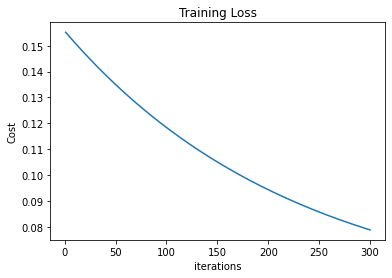

In [227]:
import matplotlib.pyplot as plt

plt.plot(np.arange(1, iterations + 1), cost_hist)
plt.xlabel("iterations")
plt.ylabel("Cost")
plt.title("Training Loss")